In [197]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox, spearmanr, kendalltau, norm, mstats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import datetime
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (18, 5)

In [157]:
df = pd.read_excel('BST_DataSet.xlsx', index_col=0)

In [158]:
df.head(30)

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669
2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680
2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673
2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519
2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779
2011-06-01,227020.0,4.934762,8.25,2.6,4.2,113.76,108.89488,6017200.0,20721.9,27.98,24137
2011-07-01,133756.0,4.777619,8.25,2.6,4.0,116.46,108.88399,6151200.0,20828.1,27.90,23598
2011-08-01,10165.0,5.215217,8.25,2.6,4.1,110.08,108.62267,6204500.0,21061.9,28.77,23051
2011-09-01,45398.0,5.873636,8.25,2.5,4.0,110.88,108.57922,6303700.0,21480.4,30.49,23468
2011-10-01,17145.0,6.443810,8.25,2.9,4.5,109.47,109.10040,6349700.0,21366.7,31.35,23602


In [159]:
df_train = df.iloc[:-12, :]

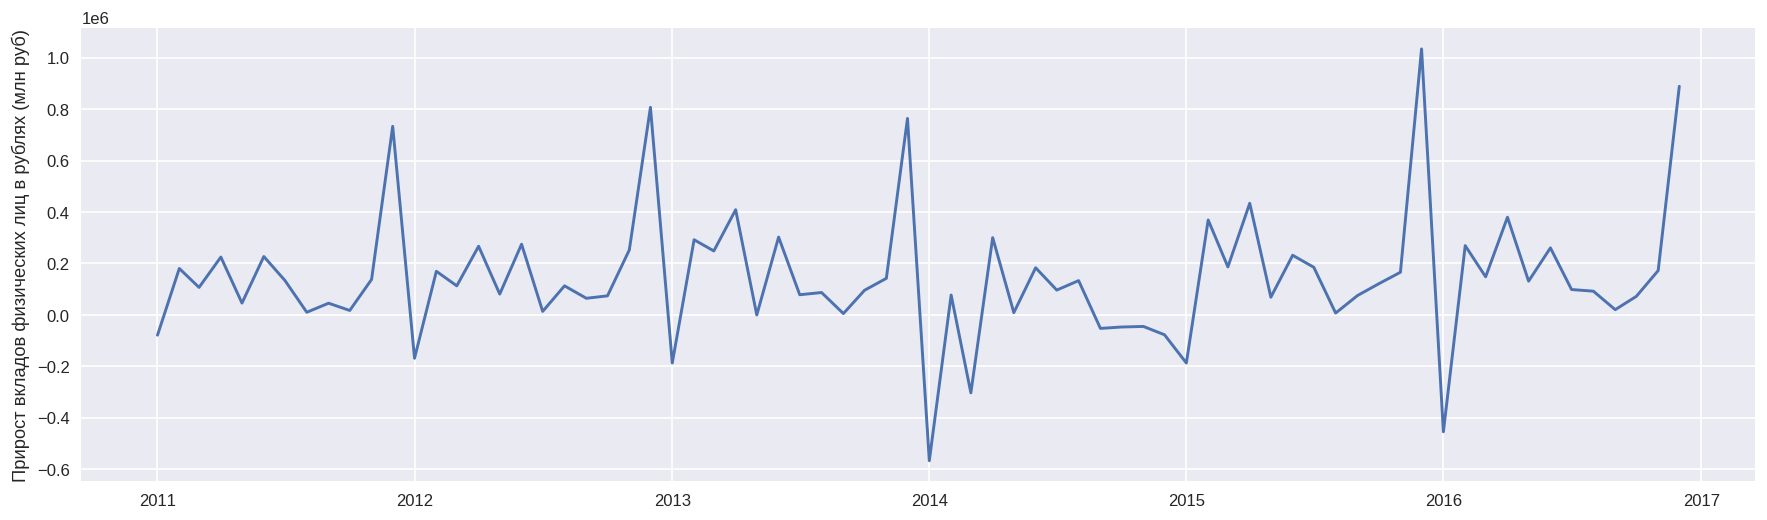

In [160]:
sns.lineplot(x=df_train.index, 
             y="Прирост вкладов физических лиц в рублях (млн руб)",
             data=df_train);

In [161]:
df_train['target'] = df_train['Прирост вкладов физических лиц в рублях (млн руб)'] - df_train['Прирост вкладов физических лиц в рублях (млн руб)'].min() + 10

In [169]:
f'p-value: {adfuller(df_train.target)[1]}'

'p-value: 0.5024228765614333'

In [170]:
if adfuller(df_train.target)[0] > adfuller(df_train.target)[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

есть единичные корни, ряд не стационарен


Ряд не стационарен

In [165]:
boxcox(df_train.target)[0]

array([2.27580791e+04, 3.12396725e+04, 2.89235852e+04, 3.26083355e+04,
       2.69555708e+04, 3.26734695e+04, 2.97772754e+04, 2.57806554e+04,
       2.69406070e+04, 2.60118640e+04, 2.99052699e+04, 4.71383898e+04,
       1.95700287e+04, 3.08986989e+04, 2.91172763e+04, 3.38887531e+04,
       2.80913481e+04, 3.41248533e+04, 2.58933676e+04, 2.91171172e+04,
       2.75635996e+04, 2.78699807e+04, 3.34500171e+04, 4.91142002e+04,
       1.88902888e+04, 3.46466692e+04, 3.33319933e+04, 3.80856132e+04,
       2.54326253e+04, 3.49551612e+04, 2.80074712e+04, 2.82875073e+04,
       2.56114334e+04, 2.85658206e+04, 3.00410374e+04, 4.79644934e+04,
       6.10403983e+00, 2.79728705e+04, 1.44104248e+04, 3.48921577e+04,
       2.57285846e+04, 3.13253508e+04, 2.85901207e+04, 2.97612390e+04,
       2.36670102e+04, 2.38519307e+04, 2.39263186e+04, 2.28126771e+04,
       1.88917293e+04, 3.69260037e+04, 3.14301895e+04, 3.88110671e+04,
       2.77024557e+04, 3.28212460e+04, 3.13815671e+04, 2.56790355e+04,
      

In [39]:
# df_train['target_bc'] = boxcox(df_train.target)[0]

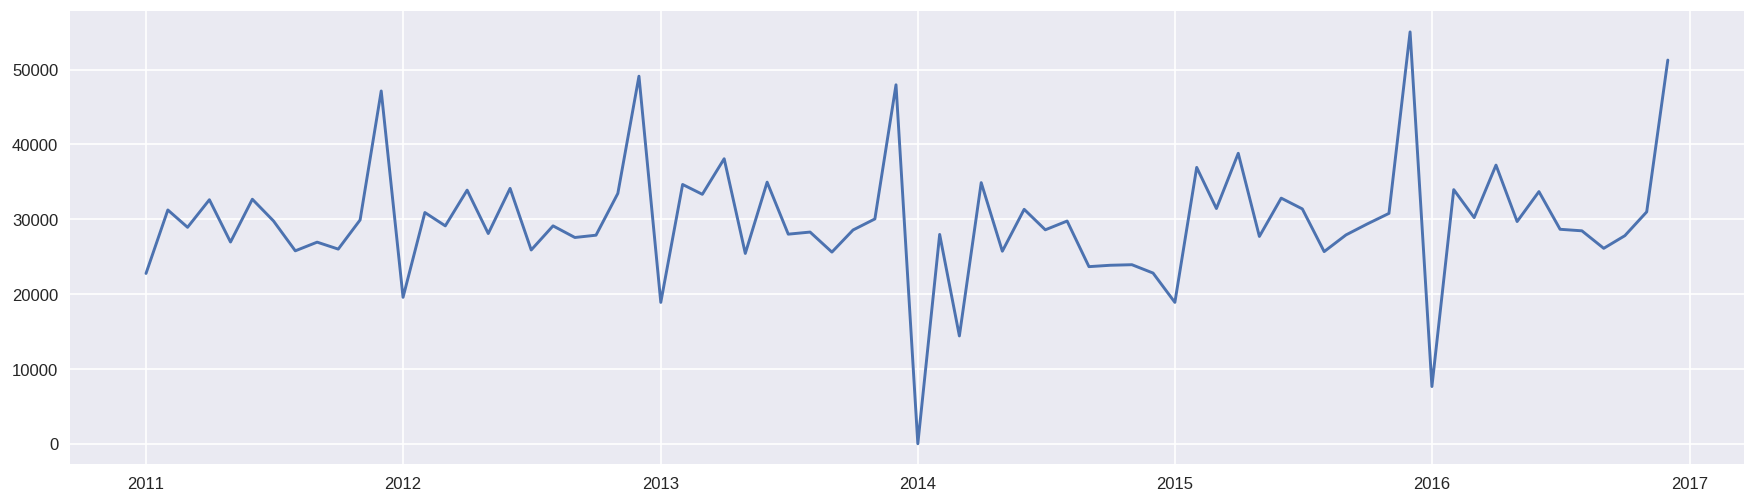

In [166]:
sns.lineplot(x=df_train.index, 
             y=boxcox(df_train.target)[0],
             data=df_train);

In [173]:
f'p-value: {adfuller(boxcox(df_train.target)[0])[1]}'

'p-value: 0.5152093555758024'

Стало хуже

In [174]:
data = df_train.target

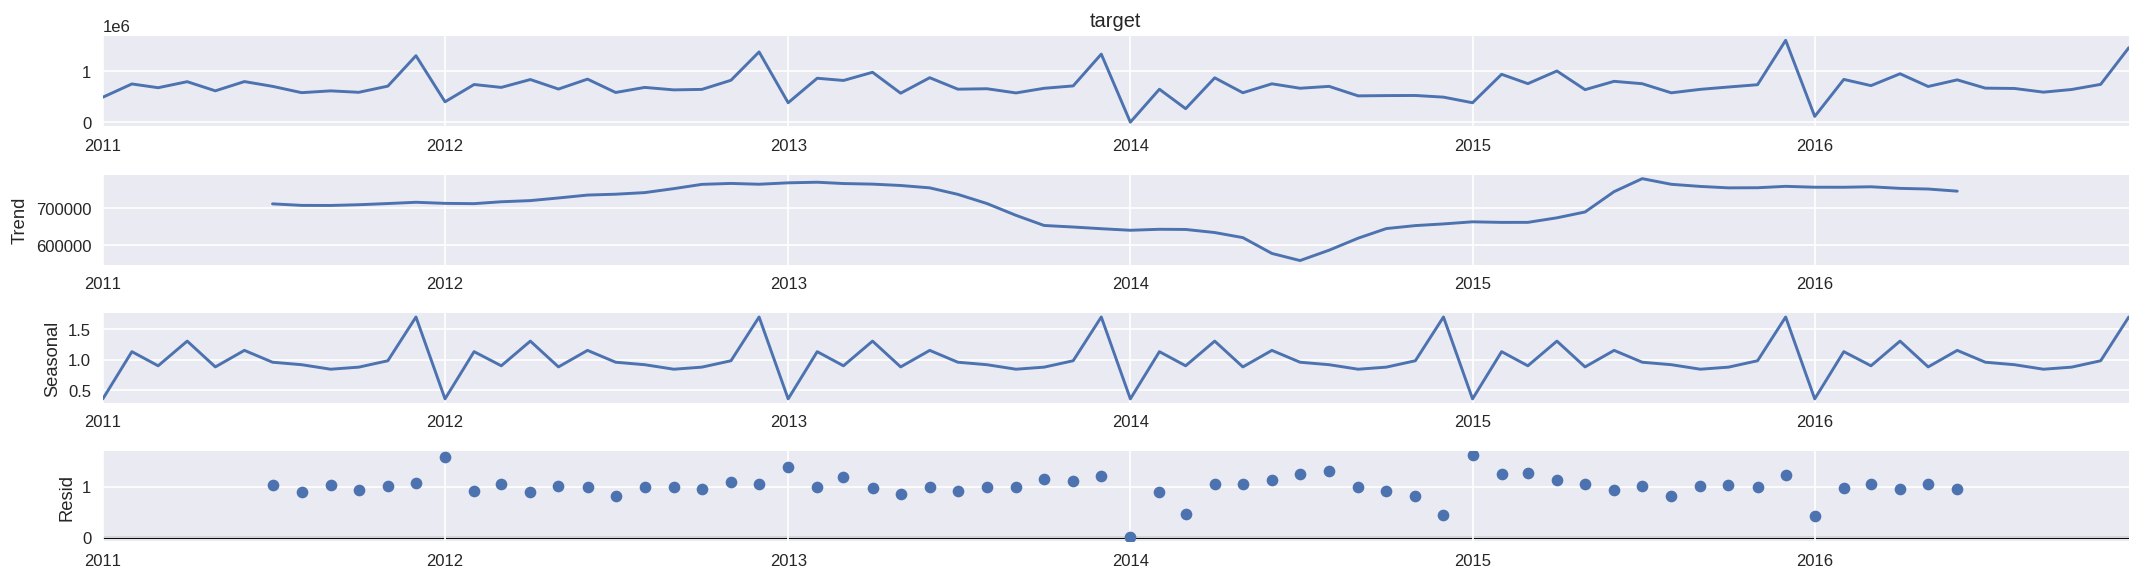

In [175]:
decompose_result = seasonal_decompose(data, model='multiplicative')
decompose_result.plot();

In [212]:
# y = df_train.target
# X = df_train.drop(['Прирост вкладов физических лиц в рублях (млн руб)', 'target', 'target_bc', 'target_bx_shift', 'target_bc_shift'], axis = 1)

In [238]:
def mk_test(ts, mode = 'simple', window = 50, alpha = 0.00001):
    """
    Mann-Kendall test for trend
    Detects linear trends (in pair with cox_stuart)
    Optimal window = 50
    Input:
        x:   a vector of data
        alpha: significance level (0.001 default)
        window: last n values, for finding trend
        mode: 
            - 'full' - if you need to know trend direction; 
            - 'simple' - if just trend existance.
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 
    """
    x = [x if x else 0 for x in ts[-window:]]
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])
    #s = [-1 if x[j] < x[k] else 1 for j in range(k+1,n) for k in range(n-1)]

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    # calculate the var(s)
    n = float(n)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
#         print(var_s)
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test

    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    if mode == 'full':
        return trend, h, p, z
    else:
#         return h, abs(z)
        return f'z: {abs(z)}, norm: {norm.ppf(1-alpha/2)}, {h}'

In [239]:
# kendalltau(y, y)

In [240]:
# spearmanr(y, y)

In [241]:
mk_test(df_train.target, mode = 'simple', window = 72, alpha = 0.05)

'z: 0.5882108973327478, norm: 1.959963984540054, False'

In [236]:
def abbe_criterion(timeseries, window = 40, alpha = .00001, debug = False):

    """
    Abbe-Linnik criterion
    Detects exponential trend (in pair with autocorrelation)
    If window >50 => too much True
    """
    if len(timeseries) < window:
        return False
    series = pd.Series([x if x else 0 for x in timeseries])
    a = series[-window:]
    mean = a.mean()
    

    X = zip(a[:-1],a[1:])
    s1 = sum([math.pow((x[0]-x[1]),2) for x in X])
    s2 = sum([pow((x-mean),2) for x in a])
    q = 0.5 * s1 / s2
    q_a = 0.6814
    n = len(a)
    Q = -(1-q)*math.sqrt((2*n+1)/(2-pow((1-q),2)))
    u = norm.ppf(alpha) #kobzar page 26
    if debug:
        print ('mean:', mean)
        print ('q:', q)
        print ('Q*:', Q)
        print ('U_alpha-1:', u)
    return f'Q: {Q}, u: {u}, {Q < u}'
# , {abs(Q)}'

In [237]:
abbe_criterion(df_train.target, window = 72, alpha = .05, debug = False)

'Q: 1.8766812708751064, u: -1.6448536269514729, False'

In [248]:
def cox_stuart(timeseries, window = 50, alpha = 0.0001, debug = False):
    """
    Cox-Stuart criterion
    H0: trend exists
    H1: otherwise
    Detects linear trends
    Optimal window = 50
    """
    n = window
    idx = np.arange(1,n+1)
    X = pd.Series([x if x else 0 for x in timeseries[-n:]], index=idx)
    
    S1 = [(n-2*i) if X[i] <= X[n-i+1] else 0 for i in range(1,n//2)]
    n = float(n)
    S1_ = (sum(S1) - n**2 / 8) / math.sqrt(n*(n**2-1)/24)
    u = norm.ppf(1-alpha/2)
    if debug:
        print('|S1*|:', abs(S1_))
        print("u:",u)
    
    return abs(S1_) > u, abs(S1_) #H0 accept

In [249]:
cox_stuart(df_train.target, window = 72, alpha = 0.0001, debug = False)

(False, 0.09623432717286111)

Наличие выраженного тренда не подтвердилось.

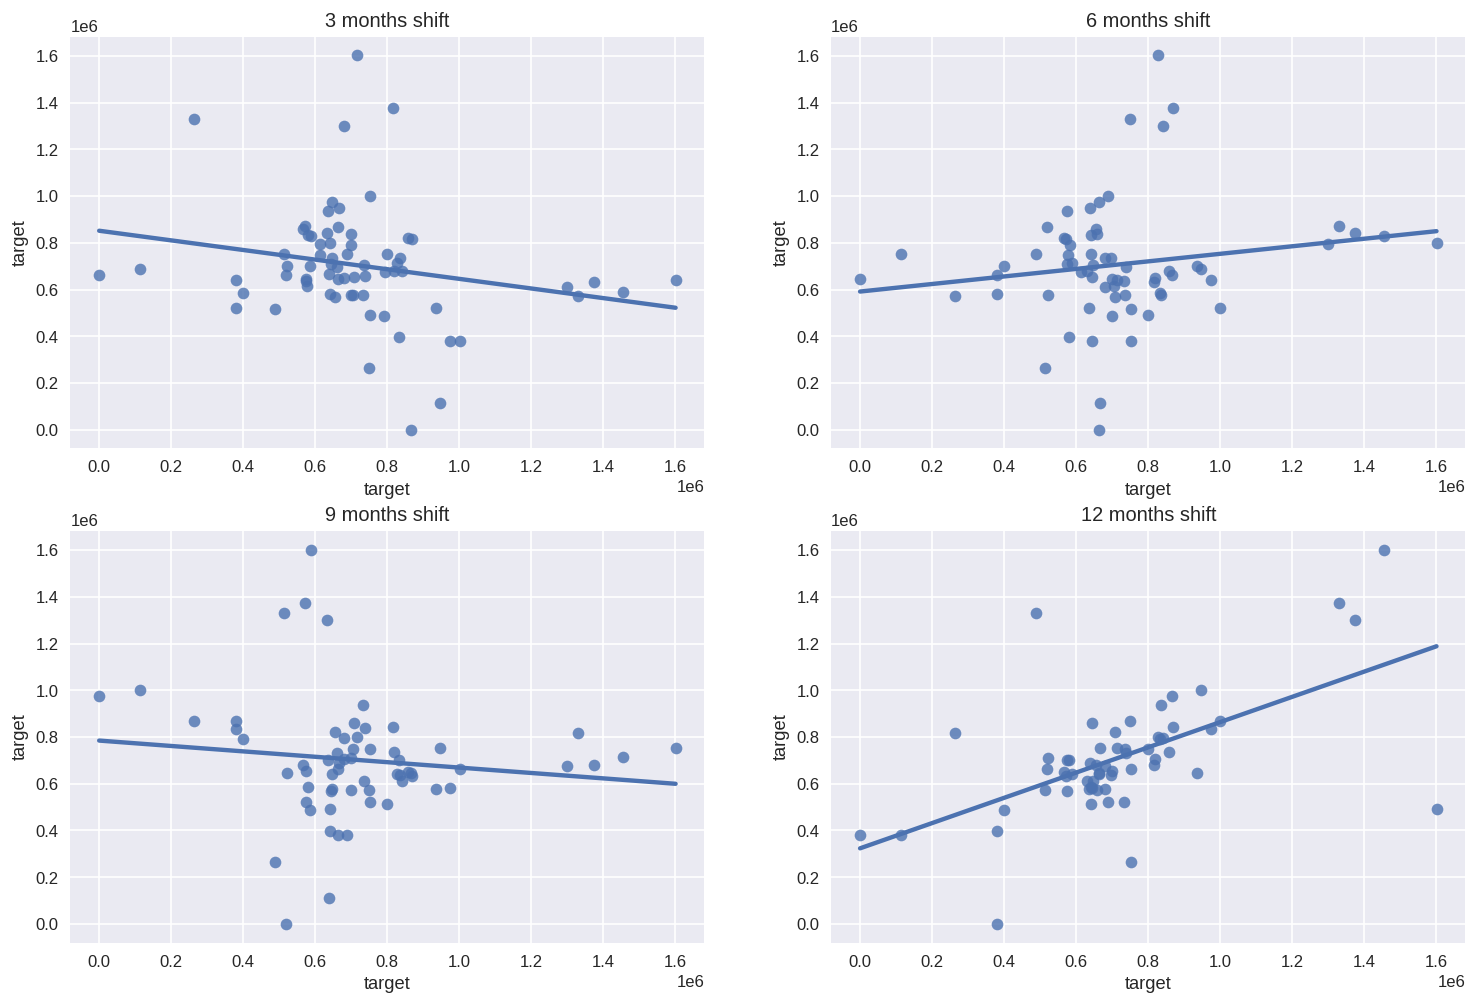

In [177]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,10))

sns.regplot(x = df_train.target, y = df_train.target.shift(3), data = df_train, ax=ax1, ci=None)
ax1.title.set_text('3 months shift')
sns.regplot(x = df_train.target, y = df_train.target.shift(6), data = df_train, ax=ax2, ci=None)
ax2.title.set_text('6 months shift')
sns.regplot(x = df_train.target, y = df_train.target.shift(9), data = df_train, ax=ax3, ci=None)
ax3.title.set_text('9 months shift')
sns.regplot(x = df_train.target, y = df_train.target.shift(12), data = df_train, ax=ax4, ci=None)
ax4.title.set_text('12 months shift');

In [57]:
# Сдвиг / shift
df_train['target_bc_shift'] = df_train['target_bc'].shift(12)

In [48]:
df_train.head(30)

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб",target,target_bc,target_bx_shift
2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669,488409.0,22758.079060,NaN
2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680,747933.0,31239.672545,NaN
2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673,674303.0,28923.585160,NaN
2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519,792348.0,32608.335458,NaN
2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779,613314.0,26955.570783,NaN
2011-06-01,227020.0,4.934762,8.25,2.6,4.2,113.76,108.89488,6017200.0,20721.9,27.98,24137,794478.0,32673.469453,NaN
2011-07-01,133756.0,4.777619,8.25,2.6,4.0,116.46,108.88399,6151200.0,20828.1,27.90,23598,701214.0,29777.275371,NaN
2011-08-01,10165.0,5.215217,8.25,2.6,4.1,110.08,108.62267,6204500.0,21061.9,28.77,23051,577623.0,25780.655397,NaN
2011-09-01,45398.0,5.873636,8.25,2.5,4.0,110.88,108.57922,6303700.0,21480.4,30.49,23468,612856.0,26940.606990,NaN
2011-10-01,17145.0,6.443810,8.25,2.9,4.5,109.47,109.10040,6349700.0,21366.7,31.35,23602,584603.0,26011.864018,NaN


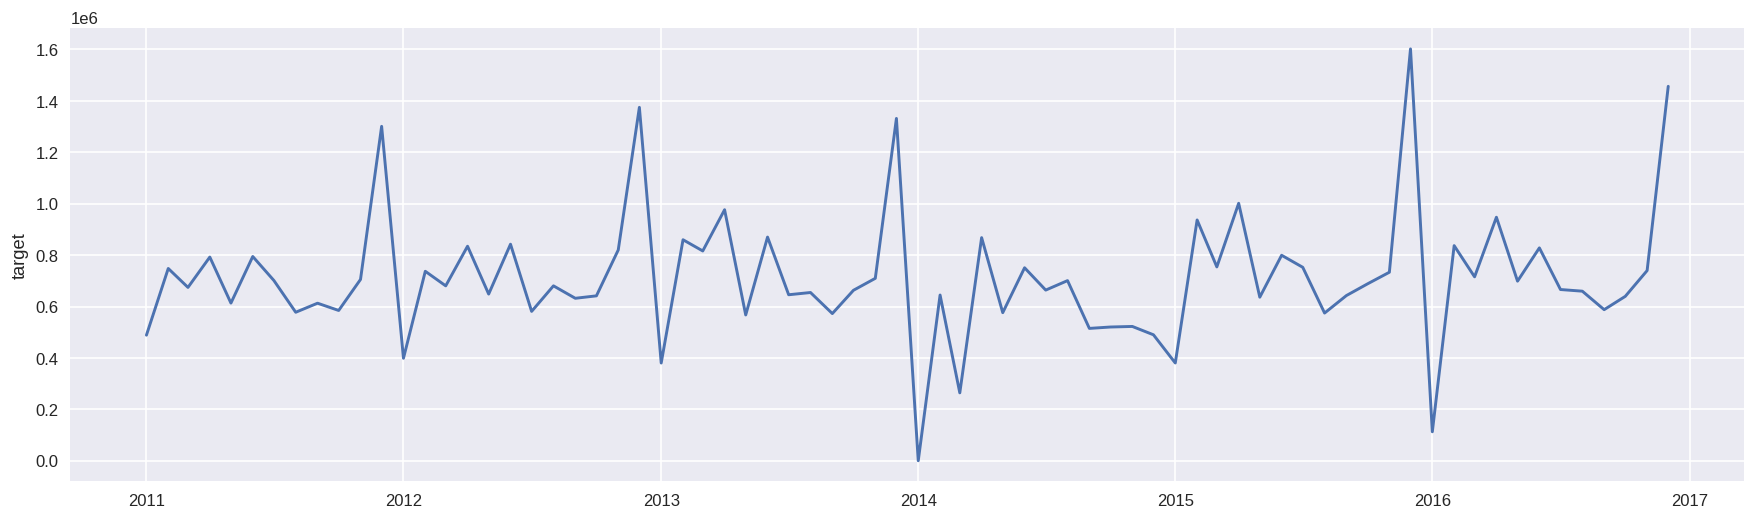

In [258]:
sns.lineplot(x=df_train.index, y="target", data=df_train);

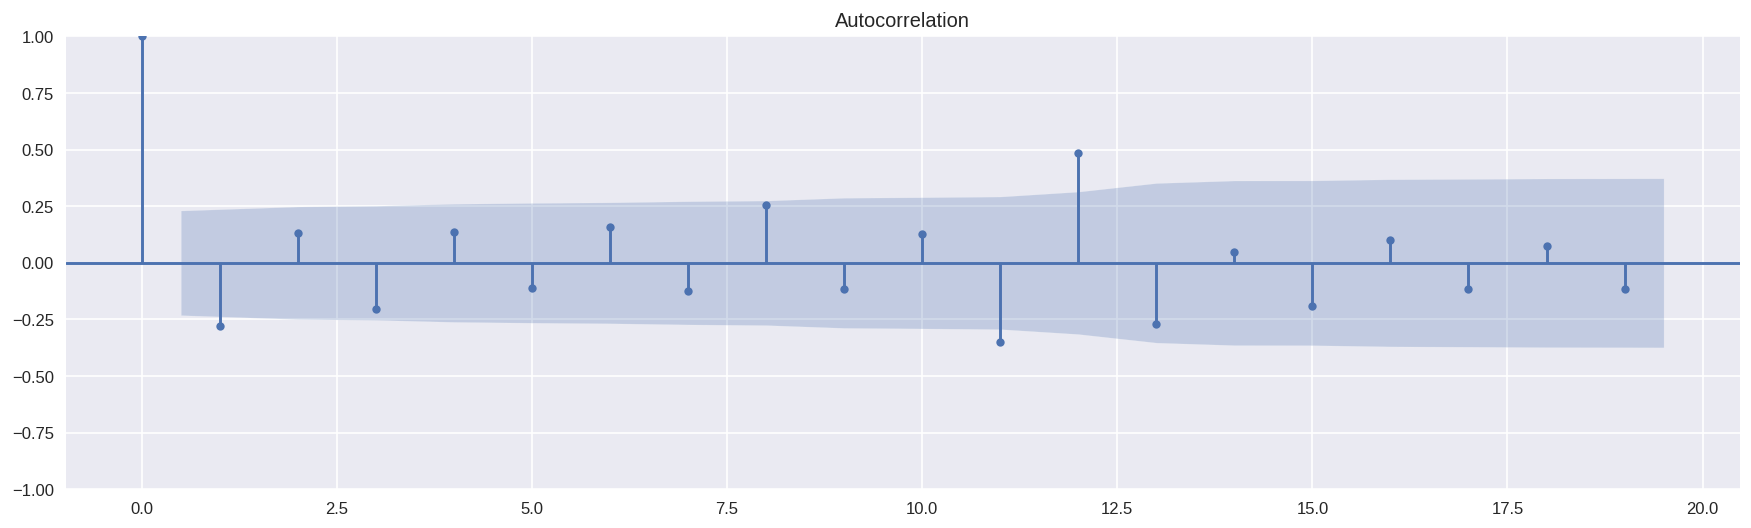

In [184]:
acf = plot_acf(df_train.target)

Синяя область - Коридор значимости критерия Стьюдента

Значимо отличаются от 0.

Значимо отличающиеся небольшие автокорреляции при больших лагах - Это происходит благодаря множественной проверке гипотез.

Поэтому автокорреляцию 1 месяц и 11 месяцев мы игнорируем.

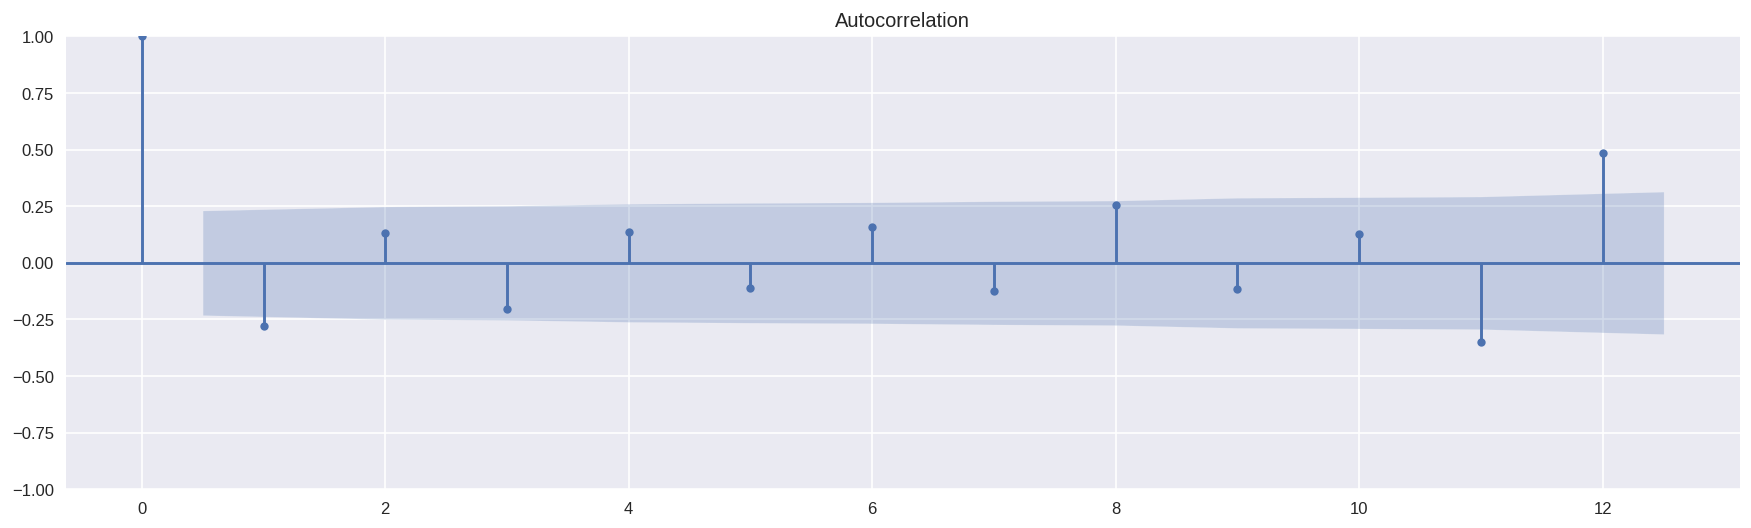

In [179]:
n_lags = 12
acf = plot_acf(df_train.target, lags=n_lags)

In [181]:
# Статистика Дарбина Уотсона в диапазоне от 0 до 4. Чем ближе к 0, тем более выраженная автокорреляция

durbin_watson(df_train.target, axis=0)

0.2804009068890242

Все данные указывают на довольно выраженную сезонность 12 месяцев.

### Сезонное дифференцирование

In [274]:
df_train['target_season'] = df_train.target - df_train.target.shift(12)

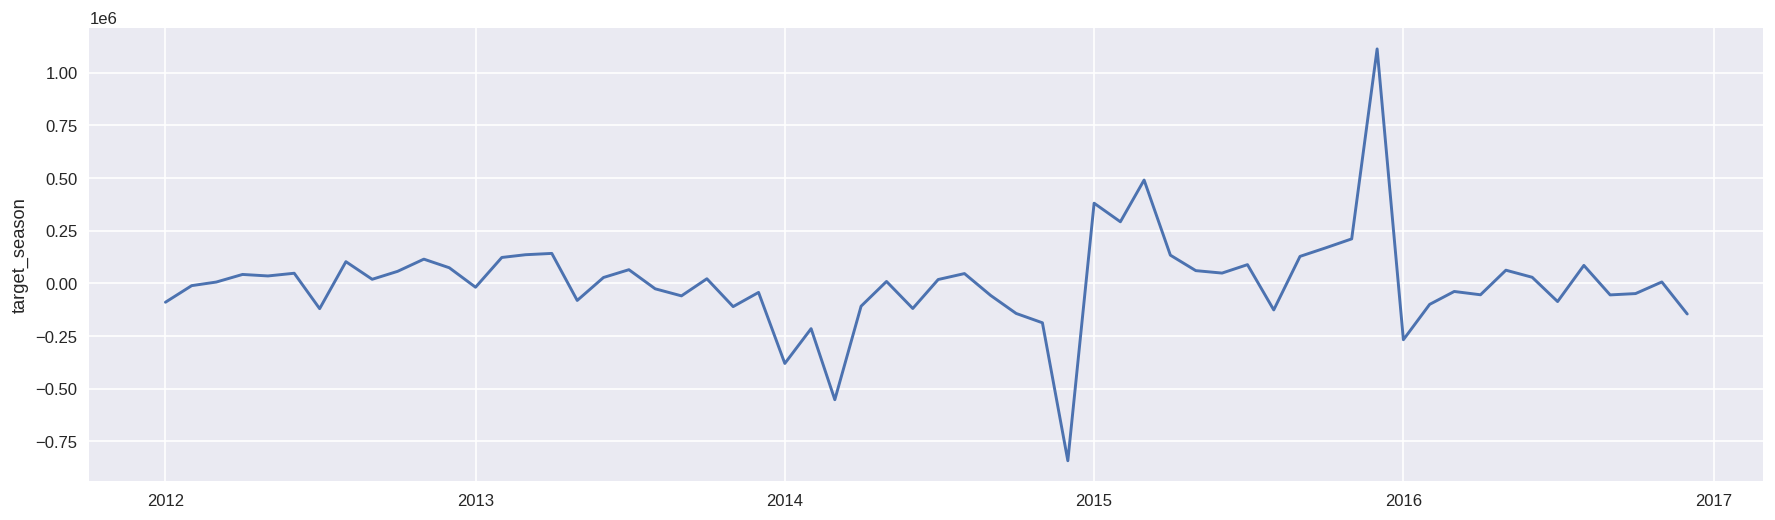

In [275]:
sns.lineplot(x=df_train.index, y="target_season", data=df_train);

In [276]:
data = df_train[12:].target_season
f'p-value: {adfuller(data)[1]}'

'p-value: 0.0854998919696277'

In [277]:
if adfuller(data)[0] > adfuller(data)[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

есть единичные корни, ряд не стационарен


Мы приближаемся к стационарному ряду

In [292]:
df_train['target_season_final'] = df_train.target - df_train.target.shift(12) + df_train.target.shift(11)

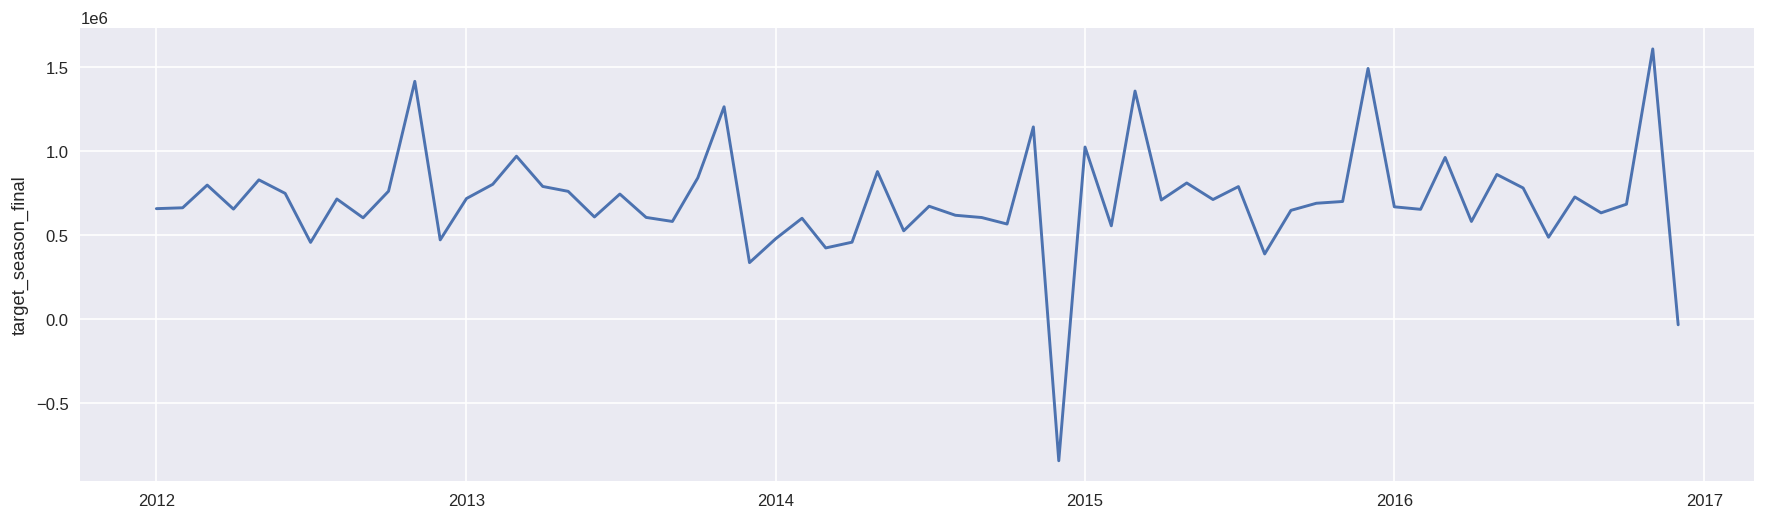

In [293]:
sns.lineplot(x=df_train.index, y="target_season_final", data=df_train);

In [294]:
data = df_train[12:].target_season_final
f'p-value: {adfuller(data)[1]}'

'p-value: 1.8076950045032496e-18'

In [295]:
if adfuller(data)[0] > adfuller(data)[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

единичных корней нет, ряд стационарен


Ура! Ряд стационарен!

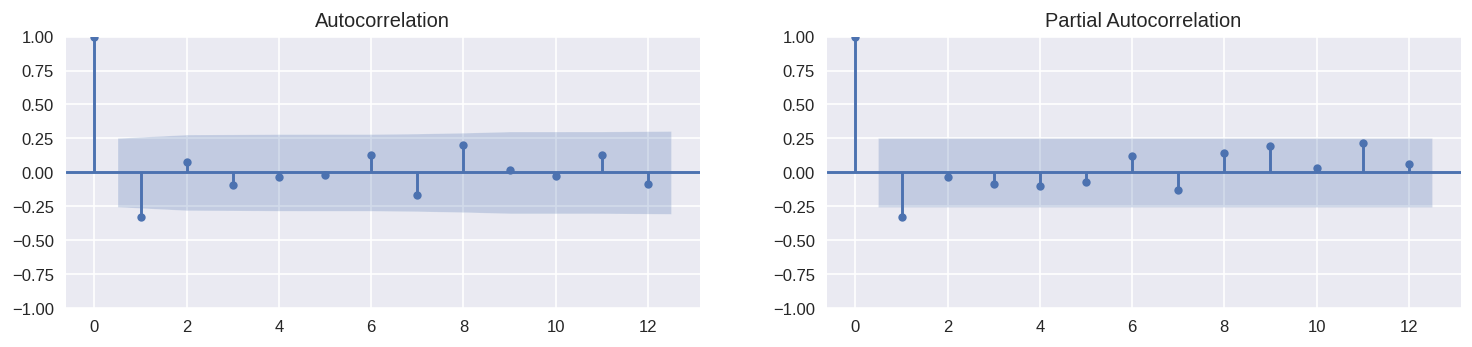

In [296]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
n_lags = 12
acf = plot_acf(data, ax=ax1, lags=n_lags)
pacf = plot_pacf(data, ax=ax2, lags=n_lags)